# Dönem Projesi: NBA Maç Sonucu Tahmini

## 1. Giriş
Bu projede, Kaggle üzerinden alınan **Historical NBA Data** veri seti kullanılarak NBA maçlarının sonuçlarını tahmin etmeye yönelik makine öğrenmesi modelleri geliştirilecektir.

**Hedef:** Ev sahibi takımın maçı kazanıp kazanmayacağını (`HomeWin`) tahmin etmek.

**Kullanılacak Modeller:**
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Decision Trees

## 2. Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


## 3. Veri Setinin Yüklenmesi ve İncelenmesi
Dosyalarımız:
- `Games.csv`: Maç genel bilgileri
- `TeamStatistics.csv`: Takım istatistikleri (Box Score)

In [2]:
games_path = 'data/Games.csv'
teams_path = 'data/TeamStatistics.csv'

try:
    df_games = pd.read_csv(games_path)
    df_teams = pd.read_csv(teams_path)
    print("Veri setleri yüklendi.")
except Exception as e:
    print(f"Hata: {e}")

df_games['gameDateTimeEst'] = pd.to_datetime(df_games['gameDateTimeEst'], format='mixed', utc=True)
df_teams['gameDateTimeEst'] = pd.to_datetime(df_teams['gameDateTimeEst'], format='mixed', utc=True)

df_teams = df_teams.sort_values('gameDateTimeEst')

print(f"Games Boyut: {df_games.shape}")
print(f"Team Stats Boyut: {df_teams.shape}")

Veri setleri yüklendi.
Games Boyut: (72470, 17)
Team Stats Boyut: (144940, 48)


## 4. Feature Engineering (Öznitelik Mühendisliği)
Maç sonucunu tahmin etmek için, maçın *oynandığı andaki* istatistiklere ihtiyacımız yok (çünkü onlar maç bitince oluşuyor). 

Bunun yerine, takımların **o maça kadar olan performanslarını** (örneğin son 10 maç ortalaması) kullanmalıyız.

**Oluşturulacak Özellikler (Rolling Averages):**
- Şut Yüzdeleri (FG%, 3P%, FT%)
- Rebound, Asist, Top Çalma, Blok
- Atılan Sayı

In [3]:
key_stats = [
    'fieldGoalsPercentage', 'threePointersPercentage', 'freeThrowsPercentage',
    'reboundsTotal', 'assists', 'steals', 'blocks', 'turnovers', 'pointsInThePaint'
]

print("Rolling Average özellikleri hesaplanıyor... (Bu işlem biraz sürebilir)")

df_rolling = df_teams.copy()

roll_window = 10
for col in key_stats:
    df_rolling[f'roll_{col}'] = df_rolling.groupby('teamId')[col].transform(
        lambda x: x.shift(1).rolling(window=roll_window, min_periods=1).mean()
    )

print("Hesaplama tamamlandı.")

Rolling Average özellikleri hesaplanıyor... (Bu işlem biraz sürebilir)
Hesaplama tamamlandı.


## 5. Veri Birleştirme (Merging)
Şimdi bu hesapladığımız 'form durumu' özelliklerini, Ev Sahibi ve Deplasman takımı olarak `Games.csv` yapısına uygun şekilde birleştireceğiz.

In [ ]:
final_df = pd.read_csv('data/final_processed_data.csv')

final_df['homeWin'] = (final_df['homeScore'] > final_df['awayScore']).astype(int)

print(f"Model için hazır veri seti boyutu: {final_df.shape}")
display(final_df.head())

Model için hazır veri seti boyutu: (157, 42)


,gameId,gameDateTimeEst,hometeamCity,hometeamName,hometeamId,awayteamCity,awayteamName,awayteamId,homeScore,awayScore,...,away_team_rolling_blocks,away_team_rolling_steals,away_team_rolling_fieldGoalsPercentage,away_team_rolling_threePointersPercentage,away_team_rolling_freeThrowsPercentage,away_team_rolling_reboundsTotal,away_team_rolling_turnovers,away_team_rolling_plusMinusPoints,away_team_rolling_pointsInThePaint,homeWin
0,22400002,2024-11-12 19:00:00+00:00,Detroit,Pistons,1610612765,Miami,Heat,1610612748,123,121,...,4.4,10.1,0.4428,0.3948,0.7440,42.8,12.6,-0.3,43.6,1
1,22400001,2024-11-12 19:00:00+00:00,Boston,Celtics,1610612738,Atlanta,Hawks,1610612737,116,117,...,4.9,9.9,0.4627,0.3487,0.7957,42.3,14.9,-6.5,53.8,0
2,22400003,2024-11-12 19:00:00+00:00,Orlando,Magic,1610612753,Charlotte,Hornets,1610612766,114,89,...,5.0,7.4,0.4325,0.3514,0.7789,46.0,15.1,-3.0,41.4,1
3,22400004,2024-11-12 19:30:00+00:00,Philadelphia,76ers,1610612755,New York,Knicks,1610612752,99,111,...,3.8,6.9,0.4893,0.3723,0.8006,41.2,11.6,2.8,48.4,0
4,22400005,2024-11-12 20:00:00+00:00,Milwaukee,Bucks,1610612749,Toronto,Raptors,1610612761,99,85,...,4.9,8.2,0.4725,0.3227,0.7408,44.4,15.5,-5.2,60.2,1


## 5.5. EDA - Exploratory Data Analysis (Keşifsel Veri Analizi)

Veri setinin genel özelliklerini ve dağılımlarını inceleyelim.

In [ ]:
print("Eksik Veri Kontrolü:")
print(final_df.isnull().sum().sum())
print("\nEksik veri sayısı:", final_df.isnull().sum().sum())
print("Toplam gözlem sayısı:", len(final_df))

if final_df.isnull().sum().sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_data = final_df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    missing_data.plot(kind='bar')
    plt.title('Eksik Veri Dağılımı')
    plt.ylabel('Eksik Veri Sayısı')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Eksik veri bulunmamaktadır.")

Eksik Veri Kontrolü:
0

Eksik veri sayısı: 0
Toplam gözlem sayısı: 157
Eksik veri bulunmamaktadır.


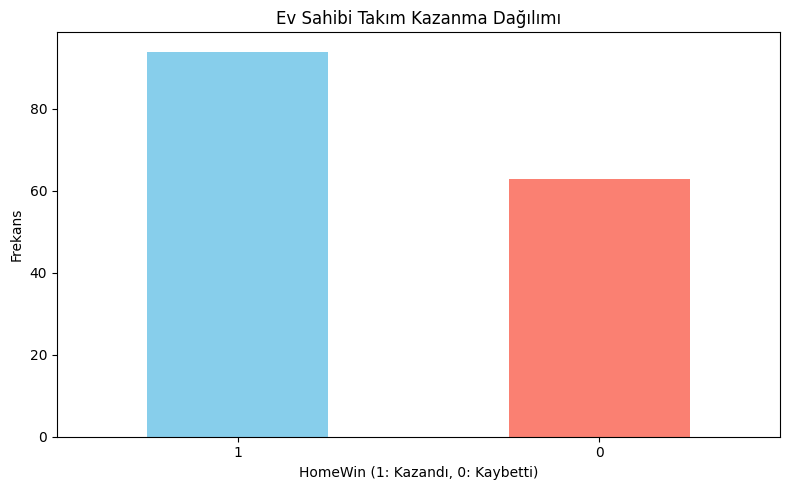

Kazanma/Oranı:
homeWin
1    94
0    63
Name: count, dtype: int64

Kazanma Yüzdesi:
homeWin
1    59.872611
0    40.127389
Name: count, dtype: float64


In [ ]:
if len(final_df) == 0:
    print("Uyarı: final_df boş! final_processed_data.csv dosyasını kontrol edin.")
elif 'homeWin' not in final_df.columns:
    print("Uyarı: homeWin kolonu bulunamadı!")
else:
    value_counts = final_df['homeWin'].value_counts()
    if len(value_counts) > 0:
        plt.figure(figsize=(8, 5))
        value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Ev Sahibi Takım Kazanma Dağılımı')
        plt.xlabel('HomeWin (1: Kazandı, 0: Kaybetti)')
        plt.ylabel('Frekans')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print("Kazanma/Oranı:")
        print(value_counts)
        print("\nKazanma Yüzdesi:")
        print(value_counts / len(final_df) * 100)
    else:
        print("Uyarı: homeWin için veri bulunamadı!")


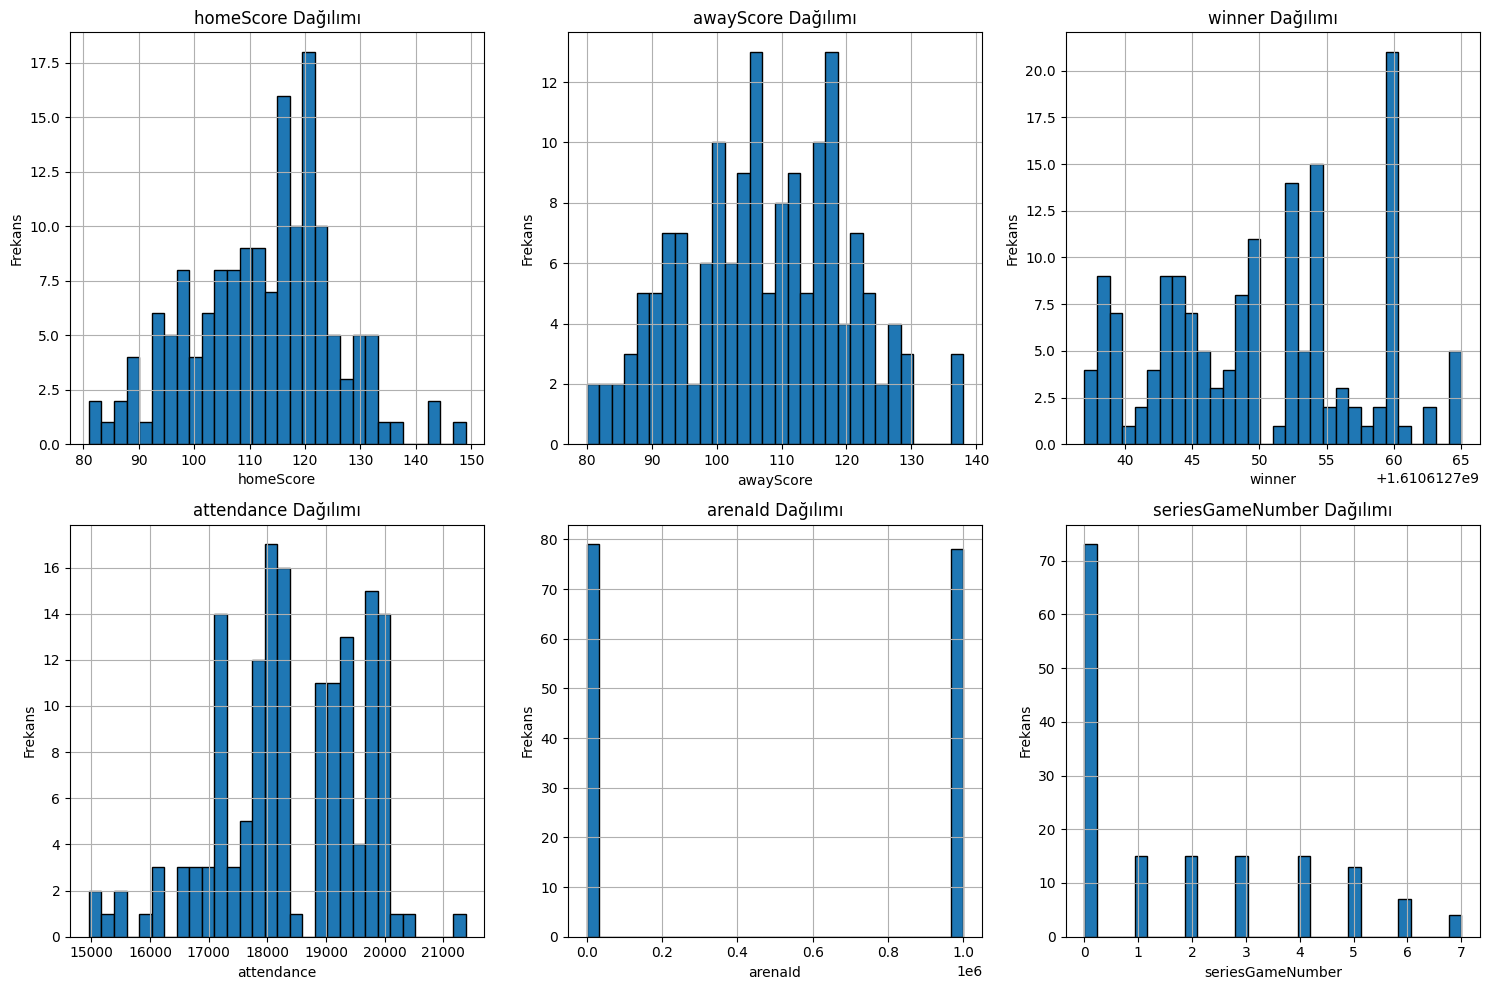

In [ ]:
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['gameId', 'hometeamId', 'awayteamId', 'homeWin']]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:6]):
    final_df[col].hist(bins=30, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'{col} Dağılımı')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frekans')

plt.tight_layout()
plt.show()

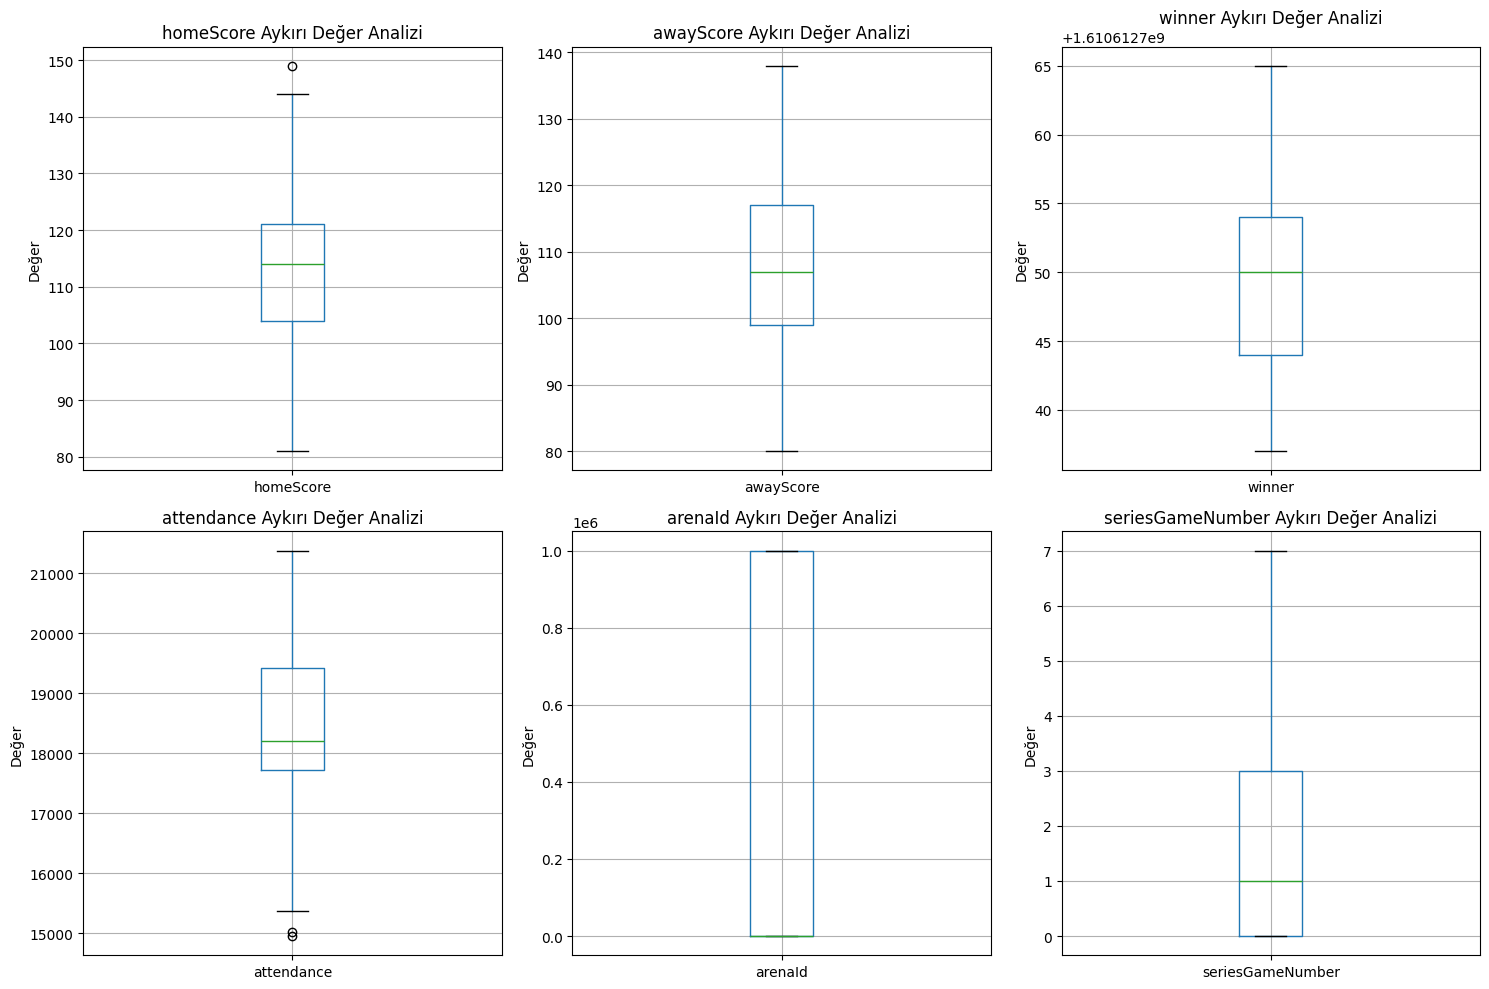

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:6]):
    final_df.boxplot(column=col, ax=axes[idx])
    axes[idx].set_title(f'{col} Aykırı Değer Analizi')
    axes[idx].set_ylabel('Değer')

plt.tight_layout()
plt.show()

## 6. Korelasyon Analizi

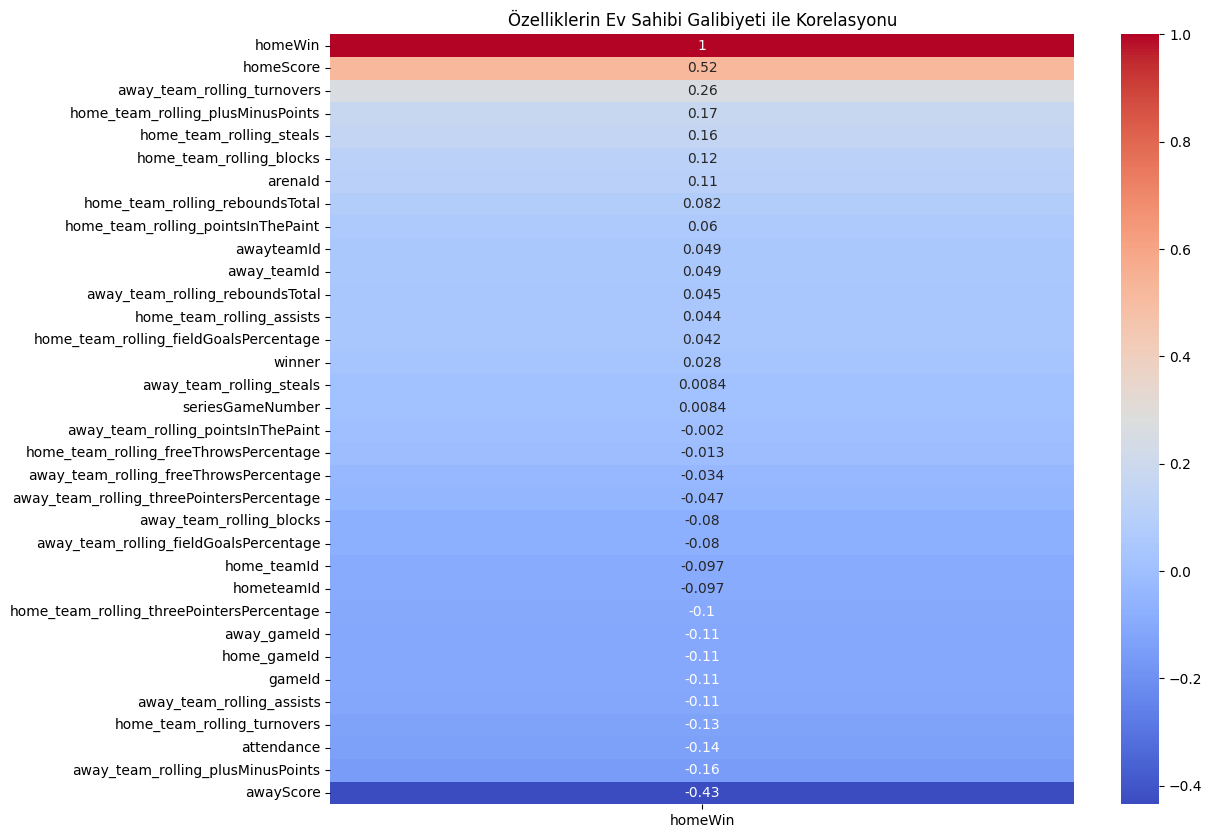

In [ ]:
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
if 'homeWin' not in numeric_cols:
    numeric_cols.append('homeWin')

plt.figure(figsize=(12, 10))
correlation_matrix = final_df[numeric_cols].corr()
sns.heatmap(correlation_matrix[['homeWin']].sort_values(by='homeWin', ascending=False), annot=True, cmap='coolwarm')
plt.title('Özelliklerin Ev Sahibi Galibiyeti ile Korelasyonu')
plt.show()


## 7. Modelleme
Veriyi Eğitim ve Test setlerine ayıralım.

In [ ]:
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()

to_drop = ['gameId', 'hometeamId', 'awayteamId', 'homeWin', 'home_gameId', 'home_teamId', 'away_gameId', 'away_teamId']
X = final_df[[col for col in numeric_cols if col not in to_drop]]
y = final_df['homeWin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Eğitim Seti: {X_train.shape}")
print(f"Test Seti: {X_test.shape}")

Eğitim Seti: (125, 26)
Test Seti: (32, 26)


### 7.1 Logistic Regression

In [11]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Sonuçları:")
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression Sonuçları:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.86      0.95      0.90        20

    accuracy                           0.88        32
   macro avg       0.88      0.85      0.86        32
weighted avg       0.88      0.88      0.87        32

Accuracy: 0.875


### 7.2 K-Nearest Neighbors (KNN)

In [12]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

print("KNN Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Sonuçları:
Accuracy: 0.65625


### 7.3 Support Vector Machine (SVM)

In [13]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Sonuçları:
Accuracy: 0.96875


### 7.4 Decision Tree

In [14]:
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Sonuçları:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Sonuçları:
Accuracy: 0.84375


## 7.5. Confusion Matrix Görselleştirmesi

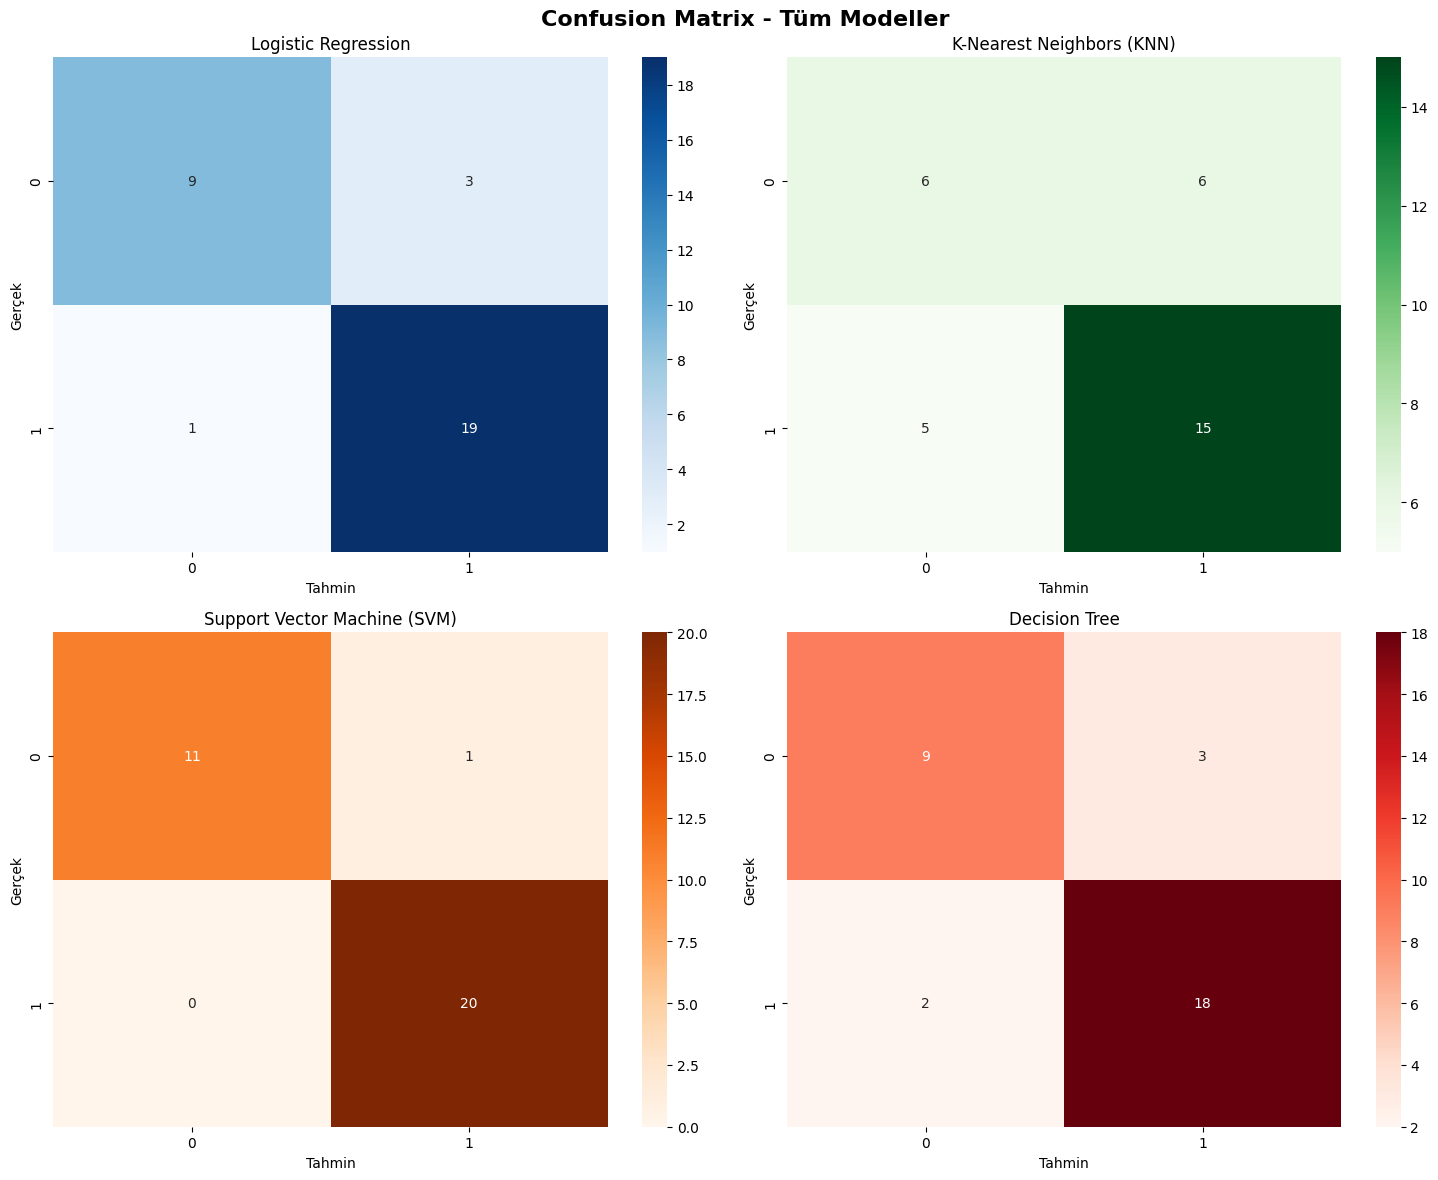


=== Confusion Matrix Özeti ===

Logistic Regression:
[[ 9  3]
 [ 1 19]]

KNN:
[[ 6  6]
 [ 5 15]]

SVM:
[[11  1]
 [ 0 20]]

Decision Tree:
[[ 9  3]
 [ 2 18]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Confusion Matrix - Tüm Modeller', fontsize=16, fontweight='bold')

cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Logistic Regression')
axes[0, 0].set_xlabel('Tahmin')
axes[0, 0].set_ylabel('Gerçek')

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_title('K-Nearest Neighbors (KNN)')
axes[0, 1].set_xlabel('Tahmin')
axes[0, 1].set_ylabel('Gerçek')

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0])
axes[1, 0].set_title('Support Vector Machine (SVM)')
axes[1, 0].set_xlabel('Tahmin')
axes[1, 0].set_ylabel('Gerçek')

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Reds', ax=axes[1, 1])
axes[1, 1].set_title('Decision Tree')
axes[1, 1].set_xlabel('Tahmin')
axes[1, 1].set_ylabel('Gerçek')

plt.tight_layout()
plt.show()

print("\n=== Confusion Matrix Özeti ===\n")
print("Logistic Regression:")
print(cm_log)
print("\nKNN:")
print(cm_knn)
print("\nSVM:")
print(cm_svm)
print("\nDecision Tree:")
print(cm_dt)

## 8. Sonuçların Karşılaştırılması

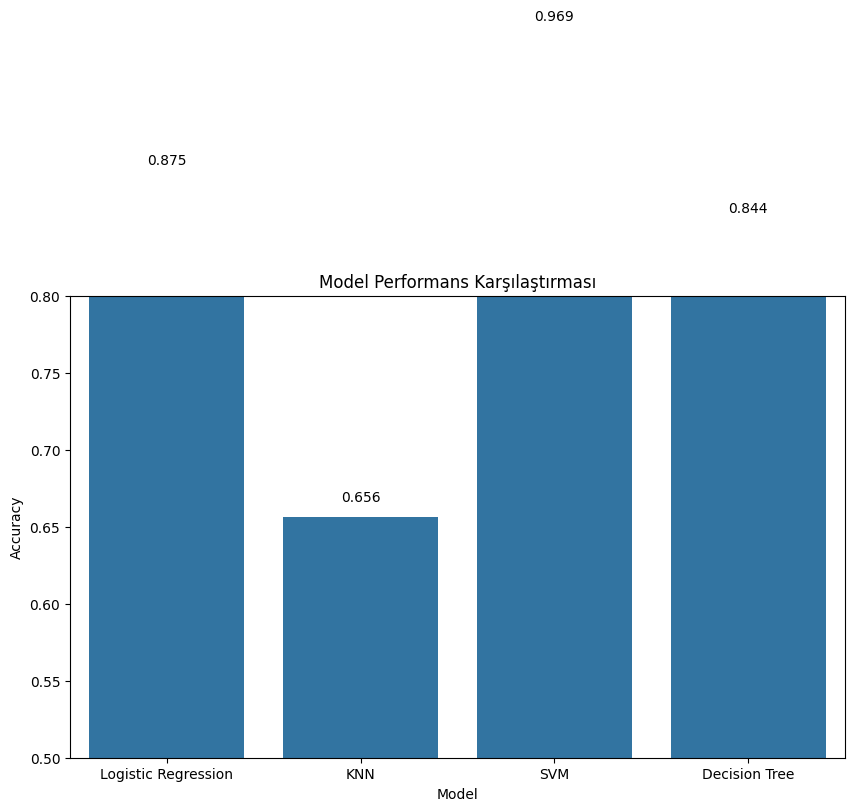

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_dt)
    ]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Performans Karşılaştırması')
plt.ylim(0.5, 0.8)
for index, row in results.iterrows():
    plt.text(index, row.Accuracy + 0.01, f"{row.Accuracy:.3f}", ha="center")
plt.show()